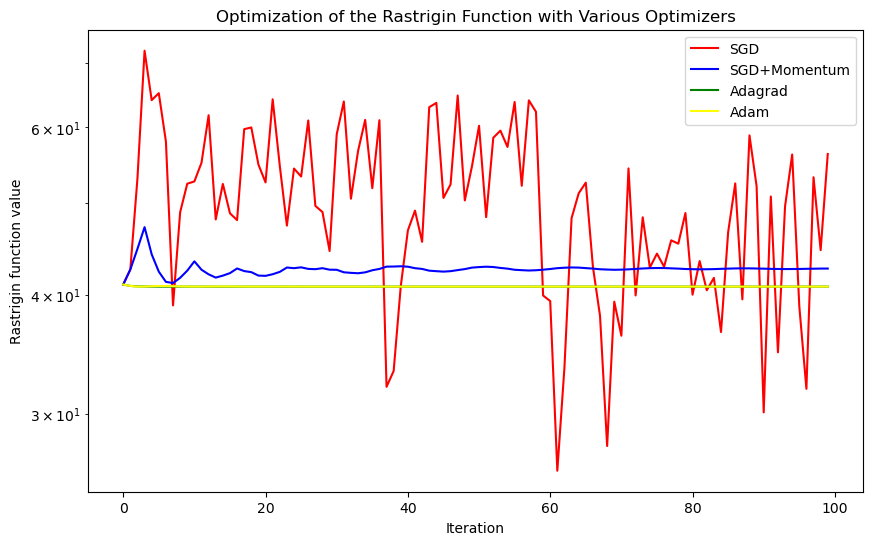

In [19]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the Rastrigin function
def rastrigin(tensor, A=10):
    x, y = tensor
    return (
        A * tensor.size(0)
        + (x**2 - A * torch.cos(2 * torch.pi * x))
        + (y**2 - A * torch.cos(2 * torch.pi * y))
    )


# Start with an initial point for optimization
x0 = torch.tensor([5.0, 4.0], requires_grad=True)


# Define the optimization function
def optimize(optimizer_class, **kwargs):
    x0 = torch.tensor(
        [5.0, 4.0], requires_grad=True
    )  # Move x0 inside to reset each call
    x = x0.clone().detach().requires_grad_(True)
    optimizer = optimizer_class([x], **kwargs)
    loss_history = []

    for _ in range(100):  # 100 iterations
        optimizer.zero_grad()
        loss = rastrigin(x)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    return loss_history, x.detach().numpy()


# Perform the optimization using different optimizers
results = {}
results["SGD"], _ = optimize(optim.SGD, lr=0.01)
results["SGD+Momentum"], _ = optimize(optim.SGD, lr=0.01, momentum=0.9)
results["Adagrad"], _ = optimize(optim.Adagrad, lr=0.01)
results["Adam"], _ = optimize(optim.Adam, lr=0.01)

plt.figure(figsize=(10, 6))
plt.plot(results["SGD"], label="SGD", color="red")
plt.plot(results["SGD+Momentum"], label="SGD+Momentum", color="blue")
plt.plot(results["Adagrad"], label="Adagrad", color="green")
plt.plot(results["Adam"], label="Adam", color="yellow")

plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Rastrigin function value")
plt.title("Optimization of the Rastrigin Function with Various Optimizers")
plt.yscale("log")  # Log scale for better visualization
plt.show()

In [20]:
print(x0)

tensor([5., 4.], requires_grad=True)


In [21]:
final_losses = {optimizer: loss[-1] for optimizer, loss in results.items()}
best_optimizer = min(final_losses, key=final_losses.get)
print(
    f"The best optimizer is {best_optimizer} with a final loss value of {final_losses[best_optimizer]}"
)

The best optimizer is Adagrad with a final loss value of 40.79296112060547


In [22]:
print(f" final loss values of {final_losses}")

 final loss values of {'SGD': 56.23556900024414, 'SGD+Momentum': 42.61620330810547, 'Adagrad': 40.79296112060547, 'Adam': 40.79296875}


In [14]:
print(final_losses)

{'SGD': 6.104970932006836, 'SGD+Momentum': 0.9065309762954712, 'Adagrad': 38.51365661621094, 'Adam': 24.493099212646484}


In [12]:
# 2.1

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd


df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
df = df.sample(frac=1, random_state=0)  # Shuffle the dataset
df = df[df[4].isin(["Iris-virginica", "Iris-versicolor"])]  # Filter to two classes

mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1

alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

targets_tr = torch.tensor(df.iloc[:75, 5].values, dtype=torch.float)
targets_va = torch.tensor(df.iloc[75:, 5].values, dtype=torch.float)
data_tr = alldata[:75]
data_va = alldata[75:]


class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.linear = nn.Linear(4, 1)

    # CALL SNIPPET FROM THE LAB
    def forward(self, x):
        h = svm(
            x, self.linear.weight, self.linear.bias
        )  # Use svm function within forward method
        return h


# SNIPPET FROM THE LAB
def svm(x, w, b):
    h = (w * x).sum(1) + b
    return h


batch_size = 25
epochs = 100
weight_decay = 0.0001
learning_rates = [0.01, 0.001, 0.0001]

train_dataset = TensorDataset(data_tr, targets_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

results = {}
for lr in learning_rates:
    for optimizer_name in ["SGD", "Adam"]:
        model = SVM()
        if optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = torch.mean(
                    torch.clamp(1 - labels * outputs, min=0)
                )  # Hinge loss for SVM
                loss.backward()
                optimizer.step()

        results[(optimizer_name, lr)] = model

In [19]:
val_dataset = TensorDataset(data_va, targets_va)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

val_accuracies = {}

for key, model in results.items():
    optimizer_name, lr = key
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = torch.sign(outputs).detach().cpu().numpy()
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum()
            total += labels.size
    val_accuracy = correct / total
    val_accuracies[key] = val_accuracy

for key, val_accuracy in val_accuracies.items():
    optimizer_name, lr = key
    variance = sum(
        [(val_accuracy - acc) ** 2 for acc in val_accuracies.values()]
    ) / len(val_accuracies)
    print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}")
    print(
        f"Expected Validation Accuracy: {val_accuracy:.4f}, Variance: {variance:.6f}\n"
    )

Optimizer: SGD, Learning Rate: 0.01
Expected Validation Accuracy: 0.9200, Variance: 0.033067

Optimizer: Adam, Learning Rate: 0.01
Expected Validation Accuracy: 0.8800, Variance: 0.025067

Optimizer: SGD, Learning Rate: 0.001
Expected Validation Accuracy: 0.6400, Variance: 0.044267

Optimizer: Adam, Learning Rate: 0.001
Expected Validation Accuracy: 0.9600, Variance: 0.044267

Optimizer: SGD, Learning Rate: 0.0001
Expected Validation Accuracy: 0.8000, Variance: 0.018667

Optimizer: Adam, Learning Rate: 0.0001
Expected Validation Accuracy: 0.6000, Variance: 0.058667



In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd


df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
df = df.sample(frac=1, random_state=0)  # Shuffle the dataset
df = df[df[4].isin(["Iris-virginica", "Iris-versicolor"])]  # Filter to two classes

mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = (2 * df[4].map(mapping)) - 1

alldata = torch.tensor(df.iloc[:, [0, 1, 2, 3]].values, dtype=torch.float)
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

targets_tr = torch.tensor(df.iloc[:75, 5].values, dtype=torch.float)
targets_va = torch.tensor(df.iloc[75:, 5].values, dtype=torch.float)
data_tr = alldata[:75]
data_va = alldata[75:]


class SVM(nn.Module):
    def __init__(self):
        super(SVM, self).__init__()
        self.linear = nn.Linear(4, 1)

    # CALL SNIPPET FROM THE LAB
    def forward(self, x):
        h = svm(
            x, self.linear.weight, self.linear.bias
        )  # Use svm function within forward method
        return h


# SNIPPET FROM THE LAB
def svm(x, w, b):
    h = (w * x).sum(1) + b
    return h


batch_size = 25
epochs = 10000
weight_decay = 0.0001
learning_rates = [0.01, 0.001, 0.0001]

train_dataset = TensorDataset(data_tr, targets_tr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

results = {}
for lr in learning_rates:
    for optimizer_name in ["SGD", "Adam"]:
        model = SVM()
        if optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = torch.mean(
                    torch.clamp(1 - labels * outputs, min=0)
                )  # Hinge loss for SVM
                loss.backward()
                optimizer.step()

        results[(optimizer_name, lr)] = model

In [22]:
val_dataset = TensorDataset(data_va, targets_va)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

val_accuracies = {}

for key, model in results.items():
    optimizer_name, lr = key
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predicted = torch.sign(outputs).detach().cpu().numpy()
            labels = labels.cpu().numpy()
            correct += (predicted == labels).sum()
            total += labels.size
    val_accuracy = correct / total
    val_accuracies[key] = val_accuracy

# Calculate expected validation accuracy and variance for each model
for key, val_accuracy in val_accuracies.items():
    optimizer_name, lr = key
    variance = sum(
        [(val_accuracy - acc) ** 2 for acc in val_accuracies.values()]
    ) / len(val_accuracies)
    print(f"Optimizer: {optimizer_name}, Learning Rate: {lr}")
    print(
        f"Expected Validation Accuracy: {val_accuracy:.4f}, Variance: {variance:.6f}\n"
    )

Optimizer: SGD, Learning Rate: 0.01
Expected Validation Accuracy: 0.8800, Variance: 0.000000

Optimizer: Adam, Learning Rate: 0.01
Expected Validation Accuracy: 0.8800, Variance: 0.000000

Optimizer: SGD, Learning Rate: 0.001
Expected Validation Accuracy: 0.8800, Variance: 0.000000

Optimizer: Adam, Learning Rate: 0.001
Expected Validation Accuracy: 0.8800, Variance: 0.000000

Optimizer: SGD, Learning Rate: 0.0001
Expected Validation Accuracy: 0.8800, Variance: 0.000000

Optimizer: Adam, Learning Rate: 0.0001
Expected Validation Accuracy: 0.8800, Variance: 0.000000



In [23]:
import torch
import math


def rastrigin(tensor, A=0.5):
    x, y = tensor
    return (
        A * tensor.size(0)
        + (x**2 - A * torch.cos(2 * math.pi * x))
        + (y**2 - A * torch.cos(2 * math.pi * y))
    )

In [24]:
import torch.optim as optim


def optimize(optimizer, x0=[5.0, 4.0], lr=0.01, momentum=None):
    x = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    if momentum:
        opt = optimizer([x], lr=lr, momentum=momentum)
    else:
        opt = optimizer([x], lr=lr)

    loss_history = []
    for _ in range(100):
        opt.zero_grad()
        loss = rastrigin(x)
        loss.backward()
        opt.step()
        loss_history.append(loss.item())

    return loss_history

In [25]:
# Initial point
initial_point = [5, 4]

# Learning rate
learning_rate = 0.01

# Optimizers
optimizers = {
    "SGD": optim.SGD,
    "SGD+Momentum": lambda params, lr, momentum: optim.SGD(
        params, lr=lr, momentum=momentum
    ),
    "Adagrad": optim.Adagrad,
    "Adam": optim.Adam,
}

# Momentum (only for SGD with Momentum)
momentum = 0.9

# Collect loss histories
loss_histories = {}
for name, opt_class in optimizers.items():
    if "Momentum" in name:
        loss_histories[name] = optimize(
            opt_class, x0=initial_point, lr=learning_rate, momentum=momentum
        )
    else:
        loss_histories[name] = optimize(opt_class, x0=initial_point, lr=learning_rate)

In [26]:
# Initial point
initial_point = [5, 4]

# Learning rate
learning_rate = 0.01

# Optimizers
optimizers = {
    "SGD": optim.SGD,
    "SGD+Momentum": lambda params, lr, momentum: optim.SGD(
        params, lr=lr, momentum=momentum
    ),
    "Adagrad": optim.Adagrad,
    "Adam": optim.Adam,
}

# Momentum (only for SGD with Momentum)
momentum = 0.9

# Collect loss histories
loss_histories = {}
for name, opt_class in optimizers.items():
    if "Momentum" in name:
        loss_histories[name] = optimize(
            opt_class, x0=initial_point, lr=learning_rate, momentum=momentum
        )
    else:
        loss_histories[name] = optimize(opt_class, x0=initial_point, lr=learning_rate)

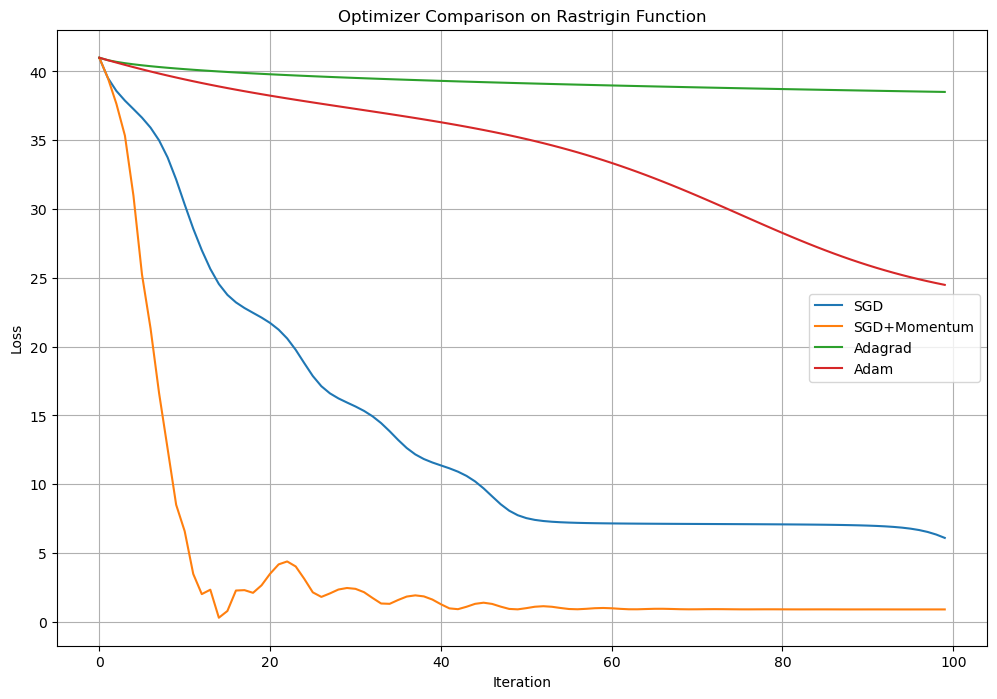

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for name, losses in loss_histories.items():
    plt.plot(losses, label=name)

plt.title("Optimizer Comparison on Rastrigin Function")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()